# Exporting data to NetCDF files <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)

## Background
NetCDF is a file format for storing multidimensional scientific data. 
This file format supports datasets containing multiple observation dates, as well as multiple bands. 
It is a native format for storing the `xarray` datasets that are produced by Open Data Cube, i.e. by `dc.load` commands. 

NetCDF files should follow [Climate and Forecast (CF) metadata conventions](http://cfconventions.org/) for the description of Earth sciences data.
By providing metadata such as geospatial coordinates and sensor information in the same file as the data, CF conventions allow NetCDF files to be "self-describing".
This makes CF-compliant NetCDFs a useful way to save multidimensional data loaded from Digital Earth Australia, as the data can later be loaded with all the information required for further analysis.

The `xarray` library which underlies the Open Data Cube (and hence Digital Earth Australia) was specifically designed for representing NetCDF files in Python. 
However, some geospatial metadata is represented quite differently between the NetCDF-CF conventions versus the GDAL (or proj4) model that is common to most geospatial software (including ODC, e.g. for reprojecting raster data when necessary). 
The main difference between `to_netcdf` (in `xarray` natively) and `write_dataset_to_netcdf` (provided by `datacube`) is that the latter is able to appropriately serialise the *coordinate reference system* object which is associated to the dataset.

## Description
In this notebook we will load some data from Digital Earth Australia and then write it to a (CF-compliant) NetCDF file using the `write_dataset_to_netcdf` function provided by `datacube`. 
We will then verify the file was saved correctly, and (optionally) clean up.

---

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import xarray as xr
from datacube.drivers.netcdf import write_dataset_to_netcdf

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Exporting_NetCDFs')

## Load data from the datacube
Here we load a sample dataset from the DEA Landsat-8 Annual Geomedian product (`ls8_nbart_geomedian_annual`).
The loaded data is multidimensional, and contains two time-steps (2015, 2016) and six satellite bands (`blue`, `green`, `red`, `nir`, `swir1`, `swir2`).

In [3]:
lat, lon = -35.282052, 149.128667  # City Hill, Canberra
radius = 0.01  # Approx. 1km

# Load data from the datacube
ds = dc.load(product='ls8_nbart_geomedian_annual',
             lat=(lat - radius, lat + radius),
             lon=(lon - radius, lon + radius),
             time=('2015', '2016'))

# Print output data
print(ds)

<xarray.Dataset>
Dimensions:  (time: 2, x: 85, y: 98)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01
  * y        (y) float64 -3.956e+06 -3.956e+06 ... -3.959e+06 -3.959e+06
  * x        (x) float64 1.549e+06 1.549e+06 1.549e+06 ... 1.551e+06 1.551e+06
Data variables:
    blue     (time, y, x) int16 569 849 852 854 709 632 ... 494 521 594 575 479
    green    (time, y, x) int16 707 1093 1105 1187 1004 ... 755 799 864 870 719
    red      (time, y, x) int16 782 1260 1255 1377 1235 ... 798 839 923 897 735
    nir      (time, y, x) int16 1951 1935 1941 1954 2294 ... 2626 2733 2894 2634
    swir1    (time, y, x) int16 1699 2335 2314 2353 2464 ... 2028 2026 2202 1876
    swir2    (time, y, x) int16 1291 1971 1989 2158 2049 ... 1279 1343 1396 1142
Attributes:
    crs:      EPSG:3577


## Export to a NetCDF file
To export a CF-compliant NetCDF file, we use the `write_dataset_to_netcdf` function:

In [4]:
write_dataset_to_netcdf(ds, 'output_netcdf.nc')

That's all.
The file has now been produced, and stored in the current working directory.

## Reading back from saved NetCDF

Let's start just by confirming the file now exists.
We can use the special `!` command to run command line tools directly within a Jupyter notebook. 
In the example below, `! ls *.nc` runs the `ls` shell command, which will give us a list of any files in the NetCDF file format (i.e. with file names ending with `.nc`).

> For an introduction to using shell commands in Jupyter, [see the guide here](https://jakevdp.github.io/PythonDataScienceHandbook/01.05-ipython-and-shell-commands.html).

In [5]:
! ls *.nc

output_netcdf.nc


We could inspect this file using external utilities such as `gdalinfo` or `ncdump`, or open it for visualisation e.g. in `QGIS`.

We can also load the file back into Python using `xarray`:

In [6]:
# Load the NetCDF from file
reloaded_ds = xr.open_dataset('output_netcdf.nc')

# Print loaded data
print(reloaded_ds)

<xarray.Dataset>
Dimensions:  (time: 2, x: 85, y: 98)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01
  * y        (y) float64 -3.956e+06 -3.956e+06 ... -3.959e+06 -3.959e+06
  * x        (x) float64 1.549e+06 1.549e+06 1.549e+06 ... 1.551e+06 1.551e+06
Data variables:
    crs      int32 ...
    blue     (time, y, x) float32 ...
    green    (time, y, x) float32 ...
    red      (time, y, x) float32 ...
    nir      (time, y, x) float32 ...
    swir1    (time, y, x) float32 ...
    swir2    (time, y, x) float32 ...
Attributes:
    date_created:           2019-12-06T10:31:41.636127
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.7+1...
    geospatial_bounds:      POLYGON ((149.115177462794 -35.2723871652199,149....
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -35.29422745465402
    geospatial_lat_max:     -35.26983245892383
    geospatial_lat_units:   degrees_north
    geosp

We can now use this reloaded dataset just like the original dataset, for example by plotting one of its colour bands:

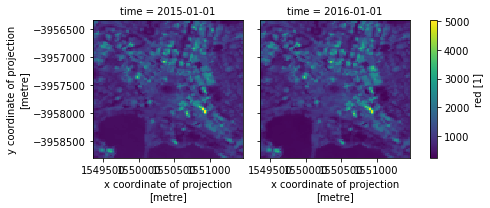

In [7]:
reloaded_ds.red.plot(col='time')

### Clean-up
To remove the saved NetCDF file that we created, run the cell below. This is optional.

In [10]:
! rm output_netcdf.nc

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)